# Mask R-CNN Training On Cell
---
Hakim Amraoui

## **1. Installation**

In [28]:
%tensorflow_version 1.x
!pip install --upgrade h5py==2.10.0
!wget https://pysource.com/extra_files/Mask_RCNN_basic_1.zip
!unzip Mask_RCNN_basic_1.zip
import sys
sys.path.append("/content/Mask_RCNN/mrcnn")
from m_rcnn import *
import matplotlib.patches as patches
from visualize import random_colors, get_mask_contours, draw_mask, random_colors, display_images
%matplotlib inline

--2022-05-22 15:40:05--  https://pysource.com/extra_files/Mask_RCNN_basic_1.zip
Resolving pysource.com (pysource.com)... 172.67.180.33, 104.21.67.193, 2606:4700:3036::ac43:b421, ...
Connecting to pysource.com (pysource.com)|172.67.180.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1282557 (1.2M) [application/zip]
Saving to: ‘Mask_RCNN_basic_1.zip.1’

Mask_RCNN_basic_1.z 100%[===================>]   1.22M  --.-KB/s    in 0.008s  

2022-05-22 15:40:05 (156 MB/s) - ‘Mask_RCNN_basic_1.zip.1’ saved [1282557/1282557]

Archive:  Mask_RCNN_basic_1.zip
replace Mask_RCNN/.gitignore? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!nvidia-smi

Mon May 16 17:18:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **2. Run Mask-RCNN on Images**

You can load here the image and extract the mask using Mask-RCNN


In [2]:
# Load Image
img = cv2.imread("/content/cell1.png")

test_model, inference_config = load_inference_model(1, "/content/mask_rcnn_object_0005.h5")
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Detect results
r = test_model.detect([image])[0]
colors = random_colors(80)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/mask_rcnn_object_0005.h5



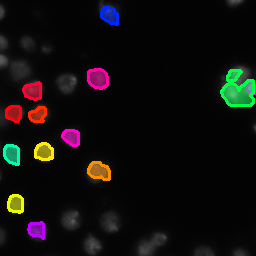

In [3]:
from google.colab.patches import cv2_imshow
# Get Coordinates and show it on the image
object_count = len(r["class_ids"])
for i in range(object_count):
    # 1. Mask
    mask = r["masks"][:, :, i]
    contours = get_mask_contours(mask)
    for cnt in contours:
        cv2.polylines(img, [cnt], True, colors[i], 2)
        img = draw_mask(img, [cnt], colors[i])

cv2_imshow(img)

In [4]:
# Extract Images
images_path = "dataset.zip"
annotations_path = "annotations.json"

extract_images(os.path.join("/content/",images_path), "/content/dataset")

Extracted: 40 images


In [5]:
dataset_train = load_image_dataset(os.path.join("/content/", annotations_path), "/content/dataset", "train")
dataset_val = load_image_dataset(os.path.join("/content/", annotations_path), "/content/dataset", "val")
class_number = dataset_train.count_classes()
print('Train: %d' % len(dataset_train.image_ids))
print('Validation: %d' % len(dataset_val.image_ids))
print("Classes: {}".format(class_number))

Annotation json path:  /content/annotations.json
Annotation json path:  /content/annotations.json
Train: 36
Validation: 4
Classes: 1


## **3. Run tests**

Compute average precision on the validation set.

In [6]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 30 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 4)
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = test_model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.7916666679084301


In [ ]:
inference_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

**Anchors**

In [8]:
# Generate Anchors

backbone_shapes = modellib.compute_backbone_shapes(inference_config, inference_config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(inference_config.RPN_ANCHOR_SCALES, 
                                          inference_config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          inference_config.BACKBONE_STRIDES, 
                                          inference_config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(inference_config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", inference_config.RPN_ANCHOR_SCALES)
print("ratios: ", inference_config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // inference_config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  65472
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 49152
Anchors in Level 1: 12288
Anchors in Level 2: 3072
Anchors in Level 3: 768
Anchors in Level 4: 192


Level 0. Anchors:  49152  Feature map Shape: [128 128]


ValueError: ignored

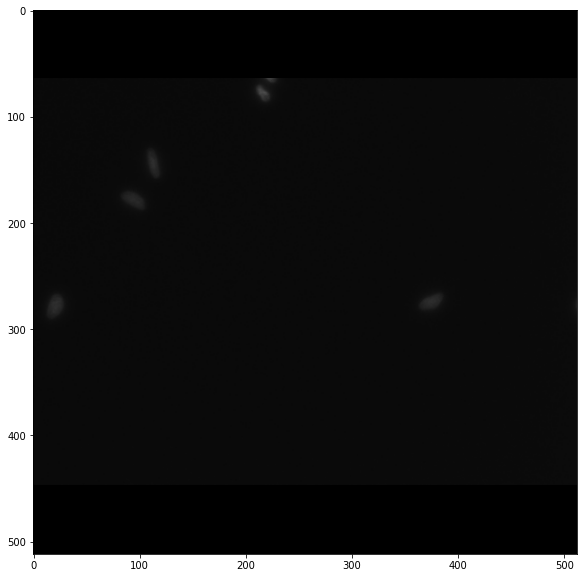

In [15]:

## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset_val.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset_val, inference_config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / inference_config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / inference_config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

**Data generator**

In [17]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset_val, inference_config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [19]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset_val.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 200, 4)           min:    0.00000  max:  511.00000  int32
mrcnn_class_ids          shape: (4, 200, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 200, 2, 4)        min:   -3.23314  max:    3.23529  float32
mrcnn_mask               shape: (4, 200, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  496.00000  int32
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 65472, 1)         min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -5.86626  max:    2.65625  float64
image_id:  2 


anchors                  shape: (65472, 4)            min: -362.03867  max:  810.03867  float64
refined_anchors          shape: (62, 4)               min:   13.00000  max:  385.00000  float32
Positive anchors: 62
Negative anchors: 194
Neutral anchors: 65216
BG                     : 178
Cell                   : 22


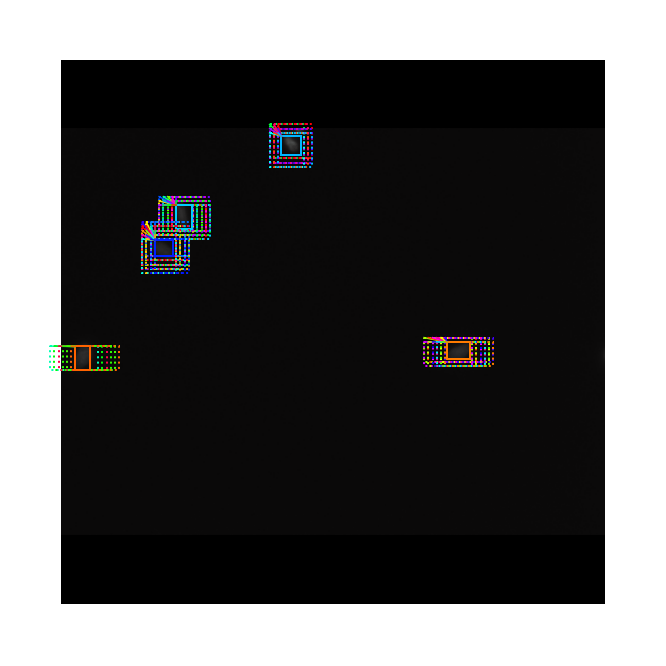

In [20]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], inference_config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * inference_config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset_val.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

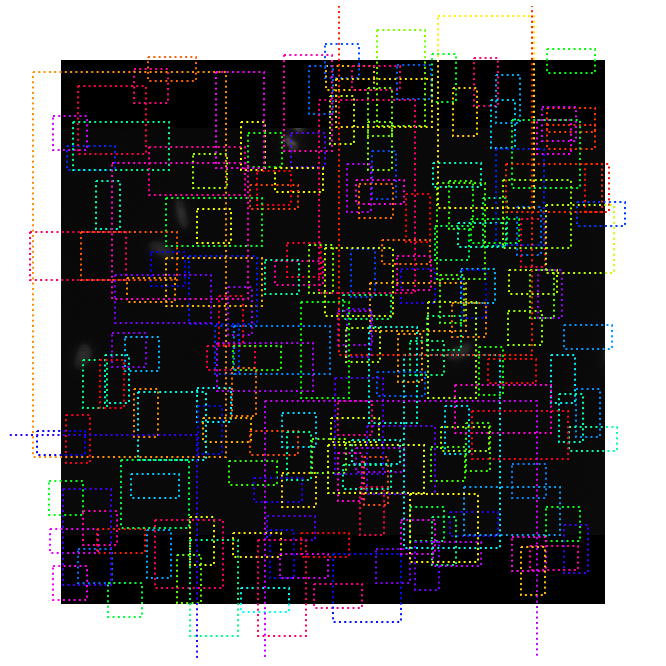

In [21]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

**ROIs**

Positive ROIs:  22
Negative ROIs:  178
Positive Ratio: 0.11
Unique ROIs: 200 out of 200


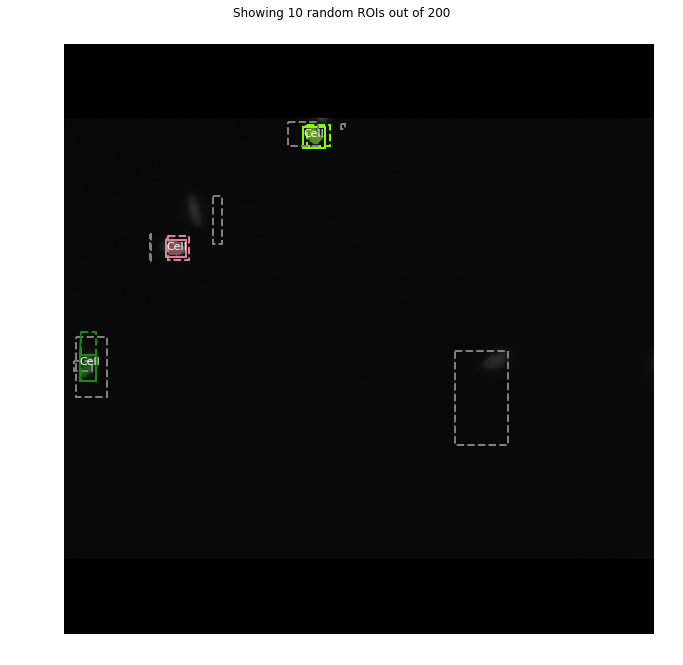

In [24]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * inference_config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset_val.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

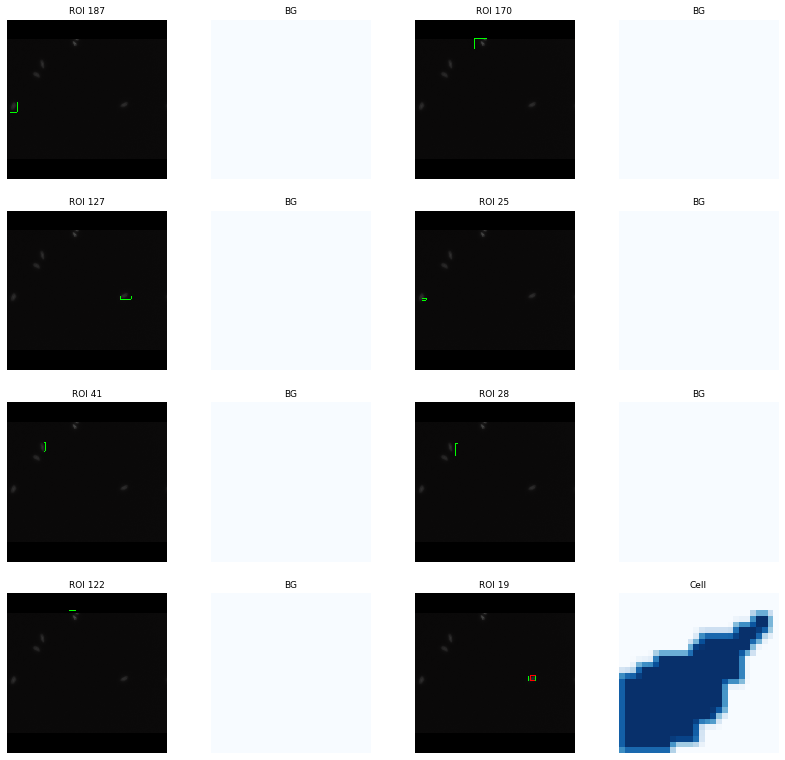

In [29]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset_val.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")